# re_LAISS

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import os
import corner
import matplotlib.pyplot as plt
import logging
from statsmodels import robust

import warnings
warnings.filterwarnings("ignore")

working_dir = os.path.abspath("")
os.chdir(working_dir)
sys.path.append('../code/')

import constants
from mod_helper_functions import *
from mod_laiss_functions import *

## Build dataset bank

In [ ]:
# Add A_V to large dataset bank

# from sfdmap2 import sfdmap

# df = pd.read_csv("../data/large_df_bank.csv")
# m = sfdmap.SFDMap('../data/sfddata-master')
# RV = 3.1
# ebv = m.ebv(df['ra'].values, df['dec'].values)
# df['A_V'] = RV * ebv
# df.to_csv("../data/large_df_bank_wAV.csv", index=False)

In [ ]:
# Join new lightcurve features to small dataset bank

# df_large = pd.read_csv("../data/large_df_bank_wAV.csv")
# df_small = pd.read_csv("../data/small_df_bank_re_laiss.csv")

# key = 'ztf_object_id'
# extra_features = [col for col in df_large.columns if col not in df_small.columns]

# merged_df = df_small.merge(df_large[[key] + extra_features], on=key, how='left')

# lc_feature_names = constants.lc_features_const.copy()
# host_feature_names = constants.host_features_const.copy()

# small_final_df = merged_df.replace([np.inf, -np.inf, -999], np.nan).dropna(subset=lc_feature_names + host_feature_names)

# small_final_df.to_csv("../data/small_hydrated_df_bank_re_laiss.csv", index=False)

In [ ]:
# lc_feature_names = constants.lc_features_const.copy()
# host_feature_names = constants.host_features_const.copy()
# raw_host_feature_names = constants.raw_host_features_const.copy()

# raw_dataset_bank = pd.read_csv('../data/large_df_bank_wAV.csv')
# print("Shape of raw dataset bank:", raw_dataset_bank.shape)

# # Impute missing values
# from sklearn.impute import KNNImputer
# X = raw_dataset_bank[lc_feature_names+raw_host_feature_names]
# feat_imputer = KNNImputer(weights='distance').fit(X)
# imputed_filt_arr = feat_imputer.transform(X)

# imputed_df = pd.DataFrame(imputed_filt_arr, columns=lc_feature_names + raw_host_feature_names)
# imputed_df.index = raw_dataset_bank.index
# raw_dataset_bank[lc_feature_names + raw_host_feature_names] = imputed_df

# imputed__df_bank = raw_dataset_bank
# print("Shape of imputed dataset bank:", imputed__df_bank.shape)

# # Build final dataset bank
# dataset_bank = re_build_dataset_bank(raw_df_bank=imputed__df_bank, av_in_raw_df_bank=True, path_to_sfd_folder="../data/sfddata-master", building_entire_df_bank=True)
# final_dataset_bank = dataset_bank.replace([np.inf, -np.inf, -999], np.nan).dropna(subset=lc_feature_names + host_feature_names)

# # Write dataset bank to .csv
# print("Shape of final dataset bank:", final_dataset_bank.shape)
# final_dataset_bank.to_csv('../data/large_final_df_bank_new_lc_feats.csv', index=False)
# print("Successfully saved dataset bank!")

## Run re_LAISS

Building new ANNOY index with 22097 transients...
Done!
ZTF21aaublej is in dataset_bank.
Loading previously saved ANNOY index without PCA: ../data/re_LAISS/index_files/re_laiss_annoy_index_pcaFalse_19lc_18host.ann
First neighbor is input transient, so it will be excluded. The final neighbor count will be one less than expected.
						 ZTFID     IAU_NAME SPEC  Z
Input transient: https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
Making a plot of stacked lightcurves...


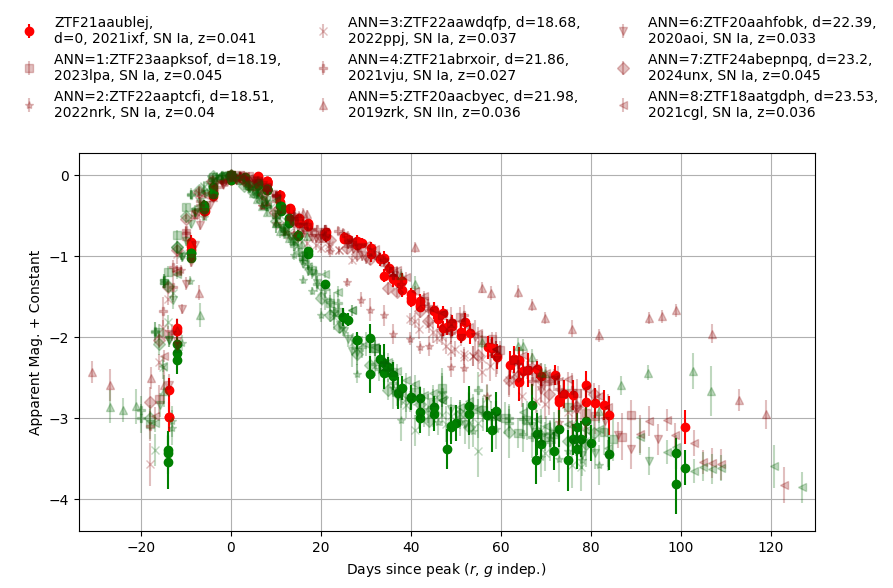

ANN=1: https://alerce.online/object/ZTF23aapksof 2023lpa SN Ia, 0.045
ANN=2: https://alerce.online/object/ZTF22aaptcfi 2022nrk SN Ia, 0.039681
ANN=3: https://alerce.online/object/ZTF22aawdqfp 2022ppj SN Ia, 0.037
ANN=4: https://alerce.online/object/ZTF21abrxoir 2021vju SN Ia, 0.026657
ANN=5: https://alerce.online/object/ZTF20aacbyec 2019zrk SN IIn, 0.0362
ANN=6: https://alerce.online/object/ZTF20aahfobk 2020aoi SN Ia, 0.033
ANN=7: https://alerce.online/object/ZTF24abepnpq 2024unx SN Ia, 0.045
ANN=8: https://alerce.online/object/ZTF18aatgdph 2021cgl SN Ia, 0.035896

ANN elapsed_time: 0.232 s

total elapsed_time: 10.133 s



In [10]:
lc_feature_names = constants.lc_features_const.copy()
host_feature_names = constants.host_features_const.copy()

# ZTF21aaublej is Ia, ZTF18acaqdaa is TDE
# For paper: Blue spiral: ZTF18abcpmwh or ZTF18ablqlzp, White eliptical: ZTF18abcvush, Reddish Elliptical: ZTF18abqlpgq
queried_ztf_id = 'ZTF21aaublej'

# theorized_lc_path = 'data/theorized_lc/slsnI.csv'
# theorized_lightcurve_df = pd.read_csv('../' + theorized_lc_path)

neighbors_df, primer_dict = re_LAISS(
    transient_ztf_id=queried_ztf_id,
    # theorized_lightcurve_df=theorized_lightcurve_df,
    # host_ztf_id_to_swap_in='ZTF21aaublej',
    path_to_dataset_bank='../data/large_final_df_bank_new_lc_feats.csv',
    path_to_timeseries_folder = '../timeseries',
    host_feature_names=host_feature_names,
    lc_feature_names=lc_feature_names,
    path_to_sfd_data_folder="../data/sfddata-master",
    use_pca=False,
    num_pca_components=None,
    force_recreation_of_annoy_index=True,
    index_folder_relative_path="../data/re_LAISS/index_files",
    neighbors=9,
    suggest_neighbor_num=False,
    max_neighbor_distance=None,
    search_k=5000,
    upweight_lc_feats_factor=1,
    return_neighbor_results=True,
    run_AD=False,
)

## re_LAISS corner plots for performance analysis

In [ ]:
remove_outliers_bool = True

logging.getLogger().setLevel(logging.ERROR)

re_laiss_features_dict = {
    'lc1': ['feature_amplitude_magn_r', 'feature_anderson_darling_normal_magn_r', 'feature_beyond_2_std_magn_r', 'feature_cusum_magn_r'],
    'lc2': ['feature_kurtosis_magn_r', 'feature_median_absolute_deviation_magn_r', 'feature_skew_magn_r', "feature_standard_deviation_magn_r"],
    'lc3': ['feature_weighted_mean_magn_r', 'feature_amplitude_magn_g', 'feature_anderson_darling_normal_magn_g', 'feature_beyond_2_std_magn_g'],
    'lc4': ['feature_cusum_magn_g', 'feature_kurtosis_magn_g', 'feature_median_absolute_deviation_magn_g'],
    'lc5': ['feature_skew_magn_g', 'feature_standard_deviation_magn_g', 'feature_weighted_mean_magn_g'],
    'g_band': ['gKronMagCorrected', 'gKronRad', 'gExtNSigma'],
    'r_band': ['rKronMagCorrected', 'rKronRad', 'rExtNSigma'],
    'i_band': ['iKronMagCorrected', 'iKronRad', 'iExtNSigma'],
    'z_band': ['zKronMagCorrected', 'zKronRad', 'zExtNSigma'],
    'band_differences': ['gminusrKronMag', 'rminusiKronMag', 'iminuszKronMag']
}

neighbor_ztfids = [link.split("/")[-1] for link in neighbors_df["ztf_link"]]

dataset_bank_df = pd.read_csv('../data/test_final_df_bank_re_laiss.csv')[['ztf_object_id'] + lc_feature_names + host_feature_names]
print("Total number of transients for corner plots:", dataset_bank_df.shape[0])

for batch_name, features in re_laiss_features_dict.items():
    print(f"Creating corner plot for {batch_name}...")

    # REMOVING OUTLIERS #
    def remove_outliers(df, threshold=7):
        df_clean = df.copy()
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            col_data = df_clean[col]
            median_val = col_data.median()
            mad_val = robust.mad(col_data)  # By default uses 0.6745 scale factor internally

            # If MAD is zero, it means the column has too little variation (or all same values).
            # In that case, skip it to avoid removing all rows.
            if mad_val == 0:
                continue

            # Compute robust z-scores
            robust_z = 0.6745 * (col_data - median_val) / mad_val

            # Keep only points where the robust z-score is within the threshold
            df_clean = df_clean[abs(robust_z) <= threshold]

        return df_clean
    
    dataset_bank_df_batch_features = dataset_bank_df[['ztf_object_id'] + features]

    if remove_outliers_bool:
        dataset_bank_df_batch_features = remove_outliers(dataset_bank_df_batch_features)
        print("Total number of transients for corner plot after outlier removal:", dataset_bank_df_batch_features.shape[0])
    else:
        dataset_bank_df_batch_features = dataset_bank_df_batch_features.replace([np.inf, -np.inf, -999], np.nan).dropna()
        print("Total number of transients for corner plot after NA, inf, and -999 removal:", dataset_bank_df_batch_features.shape[0])
    # REMOVING OUTLIERS #

    neighbor_mask = dataset_bank_df_batch_features['ztf_object_id'].isin(neighbor_ztfids)
    features_df = dataset_bank_df_batch_features[features]

    # remove 'feature_' from column names
    features_df.columns = [
        col.replace("feature_", "", 1) if col.startswith("feature_") else col
        for col in features_df.columns
    ]

    neighbor_features = features_df[neighbor_mask]
    non_neighbor_features = features_df[~neighbor_mask]
    queried_features = dataset_bank_df_batch_features[dataset_bank_df_batch_features['ztf_object_id'] == queried_ztf_id].iloc[:,1:]
    try:
        queried_features_arr = queried_features.values[0]
    except:
        print("Queried transient not found in dataset bank, using primer dict instead")
        lc_feature_names = constants.lc_features_const.copy()
        host_feature_names = constants.host_features_const.copy()

        # TODO: Define columns as they are in locus feature array
        col_order = host_feature_names

        queried_transient_feat_df = pd.DataFrame([primer_dict["locus_feat_arr"]], columns=col_order)
        queried_features_arr = queried_transient_feat_df[features].values[0]

    figure = corner.corner(non_neighbor_features, color='blue', labels=features_df.columns, plot_datapoints=True, alpha=0.3, plot_contours=False, truths=queried_features_arr, truth_color='green')
    
    # Overlay neighbor features (red) with larger, visible markers
    axes = np.array(figure.axes).reshape(len(features), len(features))
    for i in range(len(features)):
        for j in range(i):  # Only the lower triangle of the plot
            ax = axes[i, j]
            ax.scatter(
                neighbor_features.iloc[:, j], 
                neighbor_features.iloc[:, i], 
                color='red', 
                s=10,
                marker='x',
                linewidth=2
            )
    plt.show()

print("Finished creating all plots!")

### Checking frequency of TNS classes

In [ ]:
df_bank = pd.read_csv('../data/final_df_bank_re_laiss.csv')

# Count the number of unique values of column 'tns_cls' and print them
unique_counts = df_bank['tns_cls'].value_counts()
print("Number of unique values in 'tns_cls':")
print(unique_counts)

df_filt = df_bank[df_bank['tns_cls'] == 'SN Ib/c']
print(df_filt[['ztf_object_id', 'tns_cls']])